## Plots to compare the scoreing metrics 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from glob import glob
import re
from scipy.stats import mannwhitneyu

# Set default configuration for all plots
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7, 'font.family': 'sans-serif'})
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.titlesize'] = 7
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25
plt.figsize = (2,2)    

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
def melt_score_df(score_df, id_vars=['GO', 'Gene_Count']):
    columns_score = [col for col in score_df.columns if col.endswith('Score')]
    filtered_score_df = score_df[['GO', 'Gene_Count']+columns_score]
    long_scores = filtered_score_df.melt(id_vars= id_vars, var_name='Score Type', value_name='Score')
    # remove unwanted symbols and return float
    long_scores.Score = long_scores.Score.apply(lambda x: float(re.sub("[^0-9.-]", "", x)) if isinstance(x, str) else x)
    
    return long_scores


In [16]:

def plot_score_swamp(score_data, save_fig=None):
    plt.figure(figsize=(3,3))
    # plt.rcParams['pdf.fonttype'] = 42
    sns.swarmplot(x='Score Type', y='Score', data=score_data, size=3, hue='Gene_Count', palette='viridis', edgecolor='none', legend=False, alpha=1, zorder = 1)

    # # Draw lines between points with the same 'GO'
    # for name, group in long_scores.groupby('GO'):
    #     if len(group) > 1:
    #         plt.plot(group['Score Type'], group['Score'], marker='', color='grey', linewidth=1, alpha=0.5)
    
    # Calculate and draw median lines
    score_types = score_data['Score Type'].unique()
    for i, score_type in enumerate(score_types):
        # median_score = score_data[score_data['Score Type'] == score_type]['Score'].median()
        avg_score = score_data[score_data['Score Type'] == score_type]['Score'].mean()
        plt.hlines(y=avg_score, xmin=i-0.2, xmax=i+0.2, color='r', linewidth=0.75, zorder=2, linestyle='--', label='Median' if i == 0 else "")
        
    plt.xticks(ticks=np.arange(len(score_data['Score Type'].unique())),labels=['Real', 'Contaminated', 'Random'], rotation=45)

    plt.xlabel('')
    plt.ylabel('Confidence score')

    # Create a colorbar for the continuous hue
    norm = plt.Normalize(score_data['Gene_Count'].min(), score_data['Gene_Count'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])

    # Add the colorbar to the plot
    plt.colorbar(sm, label='Gene Count')
    plt.ylim(-0.02,1)
    if 'Median' in locals():
        plt.legend()
    if save_fig:
        plt.savefig(f'{save_fig}.svg', bbox_inches='tight')
        
    plt.show()

In [14]:
def plot_score_raincloud(score_data, save_fig=None):
    fig, ax = plt.subplots(figsize=(5,3))
    mpl.rcParams['font.family'] = 'Arial'
    plt.rcParams['svg.fonttype'] = 'none'
    #f3cbd3,#eaa9bd,#dd88ac,#ca699d,#b14d8e,#91357d,#6c2167
    # violin_colors = ['#ca699d','#b14d8e','#91357d']
    unique_score_types = score_data['Score Type'].unique()
    unique_score_types = unique_score_types[::-1] # default random is at the top but I want to flip it 
    # Violinplot data
    # The order parameter ensures that the violins are ordered consistently
    vp = ax.violinplot(dataset=[score_data[score_data['Score Type'] == st]['Score'] for st in unique_score_types],
                    vert=False, showmedians=True, showextrema=False, showmeans=False, widths=0.7)

    # Customize violin plots so that only the top half is shown
    for idx, body in enumerate(vp['bodies']):
        # Set the color, edge, edgewidth and transparency of the violins
        body.set_facecolor('#dd88ac')
        body.set_edgecolor('black')
        body.set_linewidth(0.25)
        body.set_alpha(0.7)
        # find the median part of the violins and clip them
        m = np.median(body.get_paths()[0].vertices[:, 1])
        body.get_paths()[0].vertices[:, 1] = np.clip(body.get_paths()[0].vertices[:, 1], m, np.inf)

    for i, st in enumerate(unique_score_types):
        # Data for this category
        data = score_data[score_data['Score Type'] == st]['Score']
        # Set y-coordinate to be just below the median of the violin plot
        y_median = np.median(vp['bodies'][i].get_paths()[0].vertices[:, 1])
        y = np.full(len(data), y_median - 0.05)
        # Add jitter and plot
        jitter = np.random.uniform(-0.5, 0.03, size=len(data))
        ax.scatter(data, y + jitter, alpha=0.8, color='tomato', edgecolor='none', s=5)

    #calculate p vals
    p_vals = calculate_p_values(score_data)
    # Annotate significance
    annotate_significance(p_vals, ax, unique_score_types)

    # Set the y-axis to show the score types instead of numerical values
    plt.yticks(ticks=np.arange(1, len(unique_score_types)+1),labels=['Random', 'Contaminated', 'Real'])
    plt.xlim(-0.02,1.15)
    # Labeling the axes and title
    plt.xlabel('Confidence score')
    sns.despine()

    if save_fig:
        plt.savefig(f'{save_fig}.svg', bbox_inches='tight')
    
    plt.show()

def calculate_p_values(score_data):
    p_values = {}
    unique_score_types = score_data['Score Type'].unique()
    # for each type of score, compare it to all other types
    for i, type1 in enumerate(unique_score_types):
        for j, type2 in enumerate(unique_score_types):
            if i < j:
                data1 = score_data[score_data['Score Type'] == type1]['Score']
                data2 = score_data[score_data['Score Type'] == type2]['Score']
                _, p_val = mannwhitneyu(data1, data2, alternative='two-sided')
                p_values[(type1, type2)] = p_val
    return p_values

def annotate_significance(p_values, ax, unique_score_types):
    # Set the initial x-offset for the significance markers
    x_offset = 1.0003  # Starting x position for the first significance marker
    x_increment = 0.03  # Incremental x-offset for each additional significance level to avoid overlap
    
    # Get the y-coordinates for each score type
    y_positions = {score_type: idx + 1 for idx, score_type in enumerate(unique_score_types)}
    
    # Iterate over the sorted p-values to draw annotations from most to least significant
    for (type1, type2), p_val in sorted(p_values.items(), key=lambda x: x[1]):
        if p_val < 0.05:  # Only annotate if p-value is significant
            y1 = y_positions[type1]
            y2 = y_positions[type2]
            
            # # Draw horizontal lines for each category
            # ax.hlines(y1, x_offset, x_offset + x_increment, color='black', lw=0.5)
            # ax.hlines(y2, x_offset, x_offset + x_increment, color='black', lw=0.5)
            
            # Draw a vertical line connecting the horizontal lines
            ax.vlines(x_offset + x_increment, y1, y2, color='black', lw=0.5)
            
            # Add the significance text to the right of the vertical line
            significance = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*'
            ax.text(x_offset + x_increment + 0.012, (y1 + y2) / 2, significance, ha='left', va='center', color='black', rotation=90)
            
            # Update the x_offset for the next significance marker
            x_offset += 2 * x_increment  # Increase the offset for the next set of annotations
    


gemini_pro


/tmp/ipykernel_240884/2778009627.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Gene Count')


<Figure size 300x300 with 0 Axes>

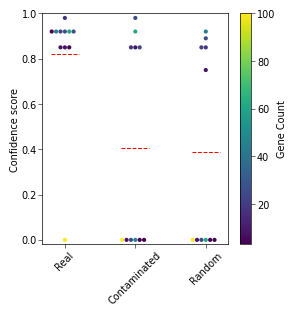

mixtral_instruct


/tmp/ipykernel_240884/2778009627.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Gene Count')


<Figure size 300x300 with 0 Axes>

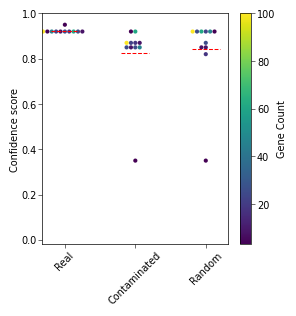

gpt_4


/tmp/ipykernel_240884/2778009627.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Gene Count')


<Figure size 300x300 with 0 Axes>

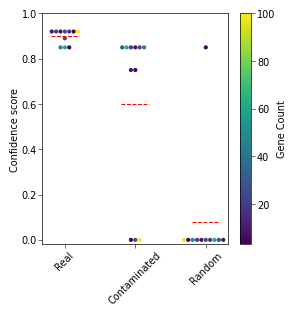

mistral_7b


/tmp/ipykernel_240884/2778009627.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Gene Count')


<Figure size 300x300 with 0 Axes>

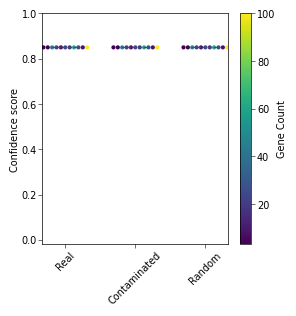

llama2_70b


/tmp/ipykernel_240884/2778009627.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Gene Count')


<Figure size 300x300 with 0 Axes>

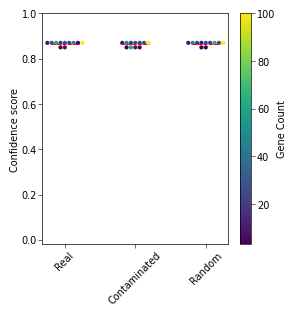

gpt_35


/tmp/ipykernel_240884/2778009627.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Gene Count')


<Figure size 300x300 with 0 Axes>

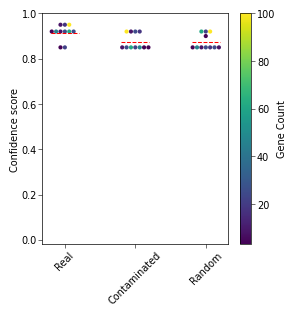

mixtral_latest


/tmp/ipykernel_240884/2778009627.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Gene Count')


<Figure size 300x300 with 0 Axes>

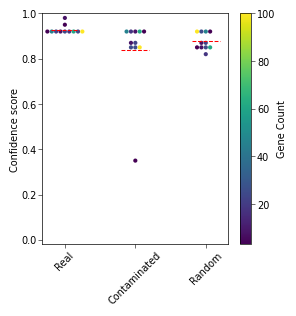

In [17]:
toyexample_files = glob('./data/GO_term_analysis/LLM_processed_toy_example*.tsv')   
toyexample_files.remove('./data/GO_term_analysis/LLM_processed_toy_example_w_contamination_llama2_7b.tsv')
for file in toyexample_files:
   
    plt.figure(figsize=(3,3))
    df = pd.read_csv(file, sep='\t')
    long_scores = melt_score_df(df)
    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    print(model_name)
    
    plot_score_swamp(long_scores)

In [18]:

result_files = glob('./data/GO_term_analysis/model_compare/LLM_processed*100set*.tsv')
# add on data to the LLM processed data based on column names 
print(result_files)

['./data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_gpt_4.tsv', './data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_gemini_pro.tsv', './data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_mixtral_instruct.tsv', './data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_llama2_70b.tsv', './data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_gpt_35.tsv']


gpt_4


/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 28.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 41.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 68.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_240884/2778009627.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, pro

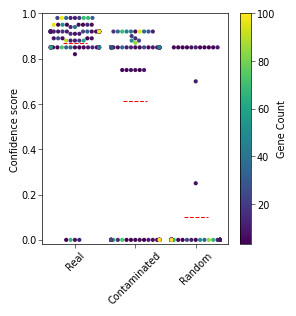

gemini_pro


/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 45.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_240884/2778009627.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, pro

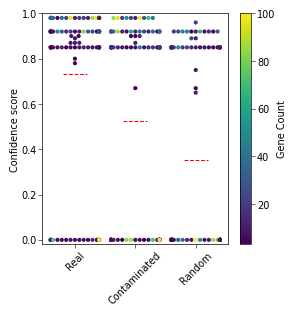

mixtral_instruct


/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 41.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 23.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_240884/2778009627.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, pro

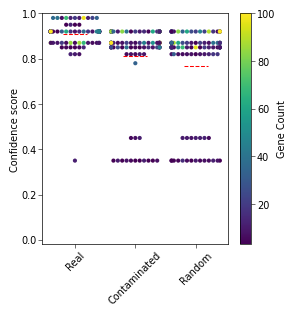

llama2_70b


/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 62.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_240884/2778009627.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Gene Count')
/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 78.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


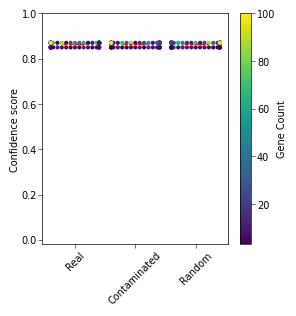

gpt_35


/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 41.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 55.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 58.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_240884/2778009627.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, pro

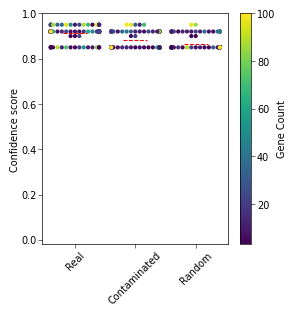

In [19]:
%matplotlib inline
for file in result_files:
    df = pd.read_csv(file, sep='\t')
    long_scores = melt_score_df(df)
    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    print(model_name)
    save_figure_name = f'./figures/model_compare/{model_name}_confidence_score_swarm'

    plot_score_swamp(long_scores, save_fig=save_figure_name)


In [20]:
# for each score distribution, calculate the p value between the distributions

for file in result_files:
    df = pd.read_csv(file, sep='\t')
    long_scores = melt_score_df(df)
    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    print(model_name)
    p_dict = calculate_p_values(long_scores)
    for key, value in p_dict.items():
        print(f'{key}: {value}')
        print('\n')

gpt_4
('gpt_4_default Score', 'gpt_4_50perc_contaminated Score'): 5.3924506335776666e-17


('gpt_4_default Score', 'gpt_4_100perc_contaminated Score'): 4.0645256150005274e-33


('gpt_4_50perc_contaminated Score', 'gpt_4_100perc_contaminated Score'): 1.9556902597674126e-17


gemini_pro
('gemini_pro_default Score', 'gemini_pro_50perc_contaminated Score'): 4.909641283668245e-05


('gemini_pro_default Score', 'gemini_pro_100perc_contaminated Score'): 2.293603421717474e-12


('gemini_pro_50perc_contaminated Score', 'gemini_pro_100perc_contaminated Score'): 0.0014306058120140488


mixtral_instruct
('mixtral_instruct_default Score', 'mixtral_instruct_50perc_contaminated Score'): 1.4310985041880264e-10


('mixtral_instruct_default Score', 'mixtral_instruct_100perc_contaminated Score'): 9.384948239661787e-17


('mixtral_instruct_50perc_contaminated Score', 'mixtral_instruct_100perc_contaminated Score'): 0.006555972015323734


llama2_70b
('llama2_70b_default Score', 'llama2_70b_50perc_contaminat

In [21]:

result_files = glob('./data/GO_term_analysis/model_compare/LLM_processed*100set*.tsv')
# add on data to the LLM processed data based on column names 
print(result_files)


['./data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_gpt_4.tsv', './data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_gemini_pro.tsv', './data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_mixtral_instruct.tsv', './data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_llama2_70b.tsv', './data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_gpt_35.tsv']


gpt_4
gpt_4_default Score:
count    100.000000
mean       0.870500
std        0.183029
min        0.000000
10%        0.850000
25%        0.850000
50%        0.920000
75%        0.920000
90%        0.950000
max        0.980000
Name: Score, dtype: float64


gpt_4_50perc_contaminated Score:
count    100.000000
mean       0.614700
std        0.386759
min        0.000000
10%        0.000000
25%        0.000000
50%        0.850000
75%        0.850000
90%        0.902000
max        0.920000
Name: Score, dtype: float64


gpt_4_100perc_contaminated Score:
count    100.000000
mean       0.103000
std        0.274121
min        0.000000
10%        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
90%        0.850000
max        0.850000
Name: Score, dtype: float64


gemini_pro
gemini_pro_default Score:
count    100.000000
mean       0.732300
std        0.371015
min        0.000000
10%        0.000000
25%        0.850000
50%        0.920000
75%        0.920000
90%        0.980000

/tmp/ipykernel_240884/198758486.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_scores)


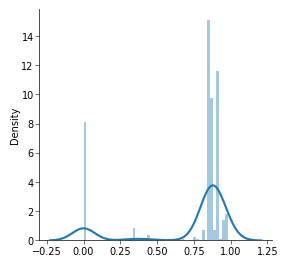

In [23]:
# for each score distribution, print the percentiles
all_scores = []
for file in result_files:
    df = pd.read_csv(file, sep='\t')
    long_scores = melt_score_df(df)
    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    print(model_name)
    for score_type in long_scores['Score Type'].unique():
        print(f'{score_type}:')
        print(long_scores[long_scores['Score Type'] == score_type]['Score'].describe(percentiles=[.1, .25, .5, .75, .9]))
        print('\n')
        # collect all scores together
        all_scores.extend(long_scores[long_scores['Score Type'] == score_type]['Score'].values)

# plot the distribution of all scores
fig, ax = plt.subplots(figsize=(3,3))
sns.distplot(all_scores)
sns.despine()   
plt.show()
        

In [24]:
# check if all zero scores are systems named 'systems of unrelated proteins'
zeros_are_unrelated = {}
zeros_with_names = {}
for file in result_files:
    df = pd.read_csv(file, sep='\t')
    score_cols = [col for col in df.columns if col.endswith('Score')]
    
    for score_col in score_cols:
        prefix = score_col.split(' ')[0]
        zeros_are_unrelated[prefix] = 0
        for i, r in df[df[score_col] == 0].iterrows():
            if 'unrelated proteins' in r[f'{prefix} Name']:
                zeros_are_unrelated[prefix] += 1
            else:
                zeros_with_names[prefix] = r['GO']
print(zeros_are_unrelated)
print(zeros_with_names)
    
## everything that is zero score is a system of unrelated proteins
    

{'gpt_4_default': 4, 'gpt_4_50perc_contaminated': 28, 'gpt_4_100perc_contaminated': 87, 'gemini_pro_default': 20, 'gemini_pro_50perc_contaminated': 41, 'gemini_pro_100perc_contaminated': 59, 'mixtral_instruct_default': 0, 'mixtral_instruct_50perc_contaminated': 0, 'mixtral_instruct_100perc_contaminated': 0, 'llama2_70b_default': 0, 'llama2_70b_50perc_contaminated': 0, 'llama2_70b_100perc_contaminated': 0, 'gpt_3.5_default': 0, 'gpt_3.5_50perc_contaminated': 0, 'gpt_3.5_100perc_contaminated': 0}
{}


### Combine all the model confidence scores and bin them 

In [25]:
combine_df = pd.DataFrame()
for file in result_files:
    df = pd.read_csv(file, sep='\t')
    long_scores = melt_score_df(df)
    
    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    print(model_name)
    long_scores['Score Type'] = long_scores['Score Type'].apply(lambda x: 'Real' if 'default' in x else 'Contaminated' if '50' in x else 'Random')
    # map the model name to my own choice of names
    long_scores['Model'] = model_name
    combine_df = pd.concat([combine_df, long_scores])

# bin scores into no score, low score, medium score, high score
bins = [-np.inf, 0, 0.79, 0.86, np.inf] # 0 is no score (name not assigned), between 0 to 0.79 is low score, between 0.8 to 0.86 is medium score, above 0.86 is high score
labels = ['Name not assigned', 'Low Confidence', 'Medium Confidence', 'High Confidence']  # Define the corresponding labels

# Apply the binning to the 'Score' column
combine_df['Score Bin'] = pd.cut(combine_df['Score'], bins=bins, labels=labels)


new_model_name = {'gpt_4': 'GPT-4', 'gemini_pro': 'Gemini Pro','gpt_35':'GPT-3.5', 'mixtral_instruct': 'Mixtral Instruct', 'llama2_70b': 'Llama2 70b'}
combine_df['Model'] = combine_df['Model'].map(new_model_name)


# And to check for a score of 0.87, which should be in 'High Score':
print(combine_df[combine_df['Score'] == 0.87])

combine_df.to_csv('./data/GO_term_analysis/model_compare/combined_scores_df.tsv', sep='\t', index=False)

gpt_4
gemini_pro
mixtral_instruct
llama2_70b
gpt_35
             GO  Gene_Count    Score Type  Score       Model        Score Bin
166  GO:0045069          85  Contaminated   0.87       GPT-4  High Confidence
78   GO:1902966           9          Real   0.87  Gemini Pro  High Confidence
79   GO:0035754           8          Real   0.87  Gemini Pro  High Confidence
81   GO:1905668          12          Real   0.87  Gemini Pro  High Confidence
124  GO:0003357          11  Contaminated   0.87  Gemini Pro  High Confidence
..          ...         ...           ...    ...         ...              ...
293  GO:1990874          61        Random   0.87  Llama2 70b  High Confidence
294  GO:0002792          46        Random   0.87  Llama2 70b  High Confidence
295  GO:1900368          25        Random   0.87  Llama2 70b  High Confidence
297  GO:2000556           8        Random   0.87  Llama2 70b  High Confidence
299  GO:0090100         100        Random   0.87  Llama2 70b  High Confidence

[279 rows x

In [31]:
print(combine_df['Model'].unique())

['GPT_3.5' 'GPT-4' 'Llama2 70b' 'Mixtral Instruct' 'Gemini Pro']


## Plot the confidence score bins with functional enrichment result 

In [32]:
## check the go term enrichment analysis result 
import pandas as pd
enrichr_res = pd.read_csv('./data/GO_term_analysis/100_GO_terms_enricher_res.tsv', sep='\t')
genes_col = [col for col in enrichr_res.columns if col.endswith('Genes')]
# create the count table

p_cutoff = 0.05
count_table = pd.DataFrame(columns=['Gene set type','Unassigned GO terms', 'Assigned GO terms'])

for col in genes_col: 
    num_enriched = sum(enrichr_res[f'{col} adj p-value'] <= p_cutoff)
    num_unassigned = sum(enrichr_res[f'{col} adj p-value'] > p_cutoff)
    count_row = pd.DataFrame({'Gene set type': col, 'Unassigned GO terms': num_unassigned, 'Assigned GO terms': num_enriched}, index=[0])
    count_table = pd.concat([count_table, count_row], ignore_index=True)

count_table


,Gene set type,Unassigned GO terms,Assigned GO terms
0,Genes,0,100
1,50perc_contaminated_Genes,3,97
2,100perc_contaminated_Genes,85,15


In [27]:
from scipy.stats import chi2_contingency

chi_square_results = pd.DataFrame(columns=['Gene set type A', 'Gene set type B', 'Chi-Square Statistic', 'Chi-Square p-value'])

# Perform chi-square tests between each combination of gene set types
for i in range(len(count_table)):
    for j in range(i+1, len(count_table)):
        # Create the contingency table for the current pair of gene set types
        contingency_table = count_table.iloc[[i, j], 1:3].values
        
        # Perform the chi-square test
        chi2_stat, p_value, dof, _ = chi2_contingency(contingency_table)
        
        # Append the results to the results DataFrame
        result = pd.DataFrame({
            'Gene set type A': [count_table['Gene set type'][i]],
            'Gene set type B': [count_table['Gene set type'][j]],
            'Chi-Square Statistic': [chi2_stat],
            'Chi-Square p-value': [p_value]
        }, index=[0]) 
        chi_square_results = pd.concat([chi_square_results, result], ignore_index=True)

chi_square_results

,Gene set type A,Gene set type B,Chi-Square Statistic,Chi-Square p-value
0,Genes,50perc_contaminated_Genes,1.353638,2.446431e-01
1,Genes,100perc_contaminated_Genes,144.368286,2.951693e-33
2,50perc_contaminated_Genes,100perc_contaminated_Genes,133.137175,8.437566e-31


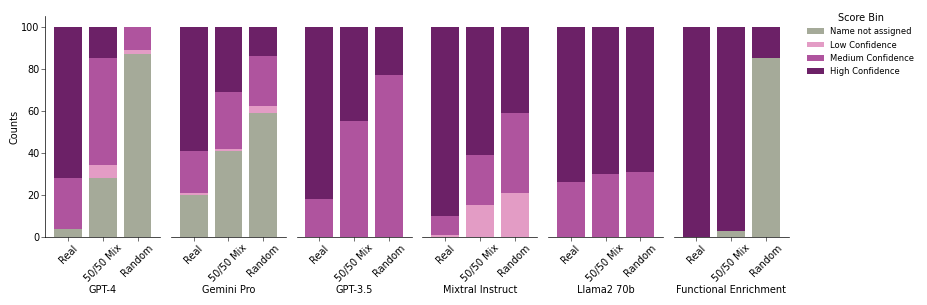

In [31]:
# Defining the custom order for Score Types and Models
score_type_order = ['Real', 'Contaminated', 'Random']
model_order = ['GPT-4', 'Gemini Pro', 'GPT-3.5', 'Mixtral Instruct', 'Llama2 70b']
score_bin_order =[ 'Name not assigned', 'Low Confidence', 'Medium Confidence', 'High Confidence']
color_palette = ['#A5AA99','#e39cc5','#af549e', '#6c2167']

combine_df = pd.read_csv('./data/GO_term_analysis/model_compare/combined_scores_df.tsv', sep='\t')
# Creating a categorical type for ordering
combine_df['Score Type'] = pd.Categorical(combine_df['Score Type'], categories=score_type_order, ordered=True)
combine_df['Model'] = pd.Categorical(combine_df['Model'], categories=model_order, ordered=True)
combine_df['Score Bin'] = pd.Categorical(combine_df['Score Bin'], categories=score_bin_order, ordered=True)

# Grouping and stacking data 
stacked_bins_data_option2 = combine_df.groupby(['Model', 'Score Type', 'Score Bin']).size().unstack().fillna(0)

# Modify the layout to include an additional subplot
fig, axes = plt.subplots(1, len(model_order) + 1, figsize=(8,3), sharey=True)

# Plotting for each model (existing code)
for i, model in enumerate(model_order):
    model_data = stacked_bins_data_option2.loc[model]
    model_data.plot(kind='bar', stacked=True, ax=axes[i], width=0.8, legend=False, color=color_palette)
    axes[i].set_xlabel(model)
    axes[i].set_xticklabels(['Real', '50/50 Mix', 'Random'], rotation=45)
    if i == 0:
        axes[i].set_ylabel('Counts')
    else:
        axes[i].yaxis.set_visible(False)

# Plotting the new stacked bar plot
count_table.plot(kind='bar', stacked=True, ax=axes[-1], x='Gene set type',y=['Unassigned GO terms', 'Assigned GO terms'], color=['#A5AA99','#6c2167'], width=0.8, legend=False)
axes[-1].set_xticklabels(['Real', '50/50 Mix', 'Random'], rotation=45)
axes[-1].set_xlabel('Functional Enrichment')
axes[-1].yaxis.set_visible(False)

# Adjusting the layout for the new plot
for i, ax in enumerate(axes):
    if i != 0:
        sns.despine(ax=ax, left=True)
    else:
        sns.despine(ax=ax)
        
plt.tight_layout()

handles, labels = axes[0].get_legend_handles_labels()

fig.legend(handles, labels, title='Score Bin', loc='upper left', bbox_to_anchor=(1, 1), fontsize=6)

# Saving the figure
plt.savefig('./figures/model_compare/combined_scores_bin_counts_by_models_with_enrichr.svg', bbox_inches='tight')
plt.show()


In [2]:
import pandas as pd
data = pd.read_csv('./data/GO_term_analysis/model_compare/combined_scores_df.tsv', sep='\t')

### Calculate significance

In [7]:
import numpy as np
from scipy.stats import chi2_contingency


# Initialize a new results list to store the pairwise chi-square test results
pairwise_results = []

# Iterate over each model
for model in data['Model'].unique():
    model_data = data[data['Model'] == model]
    
    # Define the pairs for comparison
    comparison_pairs = [
        ('Real', 'Contaminated'),  # Real vs contaminated
        ('Real', 'Random'),     # Real vs Random
        ('Contaminated', 'Random') # contaminated vs Random
    ]

    # Perform chi-square test for each pair
    for pair in comparison_pairs:
        # Creating a subset of data for the two score types being compared
        pair_data = model_data[model_data['Score Type'].isin(pair)]
        
        # Constructing the contingency table for 'Score Bin' across the selected 'Score Type'
        score_bin_table = pd.crosstab(pair_data['Score Bin'], pair_data['Score Type'])
        
        # If the table is valid, perform chi-square test, else skip
        if score_bin_table.shape[1] == 2:  # Ensure table is correct shape for comparison
            chi2, p, dof, expected = chi2_contingency(score_bin_table)
            pairwise_results.append({
                'Model': model,
                'Comparison': f"{pair[0]} vs {pair[1]}",
                'Chi-Square Statistic': chi2,
                'Chi-Square p-value': p
            })
        else:
            # Handle cases where the contingency table is not suitable for chi-square test
            pairwise_results.append({
                'Model': model,
                'Comparison': f"{pair[0]} vs {pair[1]}",
                'Chi-Square Statistic': np.nan,
                'Chi-Square p-value': np.nan
            })

# Convert the results to a DataFrame for better presentation
pairwise_results_df = pd.DataFrame(pairwise_results)
pairwise_results_df


,Model,Comparison,Chi-Square Statistic,Chi-Square p-value
0,GPT-3.5,Real vs Contaminated,27.958149,1.239678e-07
1,GPT-3.5,Real vs Random,67.448622,2.162496e-16
2,GPT-3.5,Contaminated vs Random,9.826203,1.720431e-03
3,GPT-4,Real vs Contaminated,71.064828,2.524779e-15
4,GPT-4,Real vs Random,154.531868,2.773728e-33
5,GPT-4,Contaminated vs Random,73.076017,9.362626e-16
6,Llama2 70b,Real vs Contaminated,0.223214,6.366016e-01
7,Llama2 70b,Real vs Random,0.392590,5.309412e-01
8,Llama2 70b,Contaminated vs Random,0.000000,1.000000e+00
9,Mixtral Instruct,Real vs Contaminated,24.637718,4.466707e-06


In [4]:
from glob import glob
import pandas as pd
import numpy as np
files = glob('./data/GO_term_analysis/model_compare/LLM_processed*100set*.tsv')


In [5]:
def bin_scores(df, score_col, prefix):
    # bin scores into no score, low score, medium score, high score
    bins = [-np.inf, 0, 0.79, 0.86, np.inf] # 0 is no score (name not assigned), between 0 to 0.79 is low score, between 0.8 to 0.86 is medium score, above 0.86 is high score
    labels = ['Name not assigned', 'Low Confidence', 'Medium Confidence', 'High Confidence']  # Define the corresponding labels

    # Apply the binning to the 'Score' column
    df[f'{prefix} Score Bin'] = pd.cut(df[score_col], bins=bins, labels=labels)

for file in files:
    model = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    print(model)
    df = pd.read_csv(file, sep='\t')
    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    # print(model_name)
    if model_name == 'gpt_35':
        prefix = 'gpt_3.5'
    else:
        prefix = model_name
    
    score_cols = [col for col in df.columns if col.endswith('Score')]
    for col in score_cols:
        long_prefix = col.split(' ')[0]
        print(long_prefix)
        bin_scores(df, col, long_prefix)
    df.to_csv(file, sep='\t', index=False)


gpt_4
gpt_4_default
gpt_4_50perc_contaminated
gpt_4_100perc_contaminated
gemini_pro
gemini_pro_default
gemini_pro_50perc_contaminated
gemini_pro_100perc_contaminated
mixtral_instruct
mixtral_instruct_default
mixtral_instruct_50perc_contaminated
mixtral_instruct_100perc_contaminated
llama2_70b
llama2_70b_default
llama2_70b_50perc_contaminated
llama2_70b_100perc_contaminated
gpt_35
gpt_3.5_default
gpt_3.5_50perc_contaminated
gpt_3.5_100perc_contaminated
